In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import seaborn as sns
import glob
import numpy as np
import requests
%matplotlib inline

In [2]:
rc_config = {"axes.titlesize" : 24,
            "axes.labelsize" : 20,
#             "lines.linewidth" : 3,
#             "lines.markersize" : 10,
            "xtick.labelsize" : 16,
            "ytick.labelsize" : 16,
            "figure.titlesize":35,
            'figure.facecolor': 'white',
            "legend.frameon":False,
             "legend.fontsize":16
            }

## Construct a table to annotate all mitochondrial SNP variation

We can obtain all mtDNA loci from https://www.mitomap.org/foswiki/bin/view/MITOMAP/GenomeLoci --- which can be saved to a csv

We can obtain annotations for variants at HmtVar: https://www.hmtvar.uniba.it/api/ using the requests module. We choose three annotations of interest

In [3]:
mtDNA_genetic_loci = pd.read_excel("../../config_dir/mtDNA_annotations/mito_master_annotations.xlsx")

In [4]:
mtDNA_genetic_loci = mtDNA_genetic_loci.set_index("Map Locus")

In [5]:
# generated from the mitochondrial gtf file
gene_names = pd.read_csv("../../config_dir/mtDNA_annotations/human_mtDNA_gene_locs.txt")

In [6]:
genes = (list(gene_names["name"][gene_names["name"] != "trna"].iloc[:-2]) +
list(mtDNA_genetic_loci["Description"][mtDNA_genetic_loci["Description"].str.contains("tRNA")].index))

In [7]:
# obtain additional information from wikipedia about the kind of gene types
gene_types = pd.read_html("https://en.wikipedia.org/wiki/Mitochondrial_DNA")[1][["Gene","Strand","Type"]].rename(columns={"Gene":"locus"})

In [8]:
gene_types = gene_types.groupby("locus").tail(1).reset_index() # drop humanin from the table for ease

In [9]:
# pick only the 37 main genes
mtDNA_genetic_loci = mtDNA_genetic_loci.loc[genes].sort_values("Starting")
# clip the overlapping genes
locus_positions = mtDNA_genetic_loci.apply(lambda x: list(range(x["Starting"],x["Ending"] + 1 )), axis=1 ).explode().to_frame("Position").reset_index().groupby("Position").head(1)

In [10]:
locus_positions = pd.concat(objs=[locus_positions.groupby("Map Locus").head(1).set_index("Map Locus").rename(columns={"Position":"start"}),
           locus_positions.groupby("Map Locus").tail(1).set_index("Map Locus").rename(columns={"Position":"end"})],
          axis=1
         )

In [11]:
locus_positions

start    end
Map Locus              
MT-TF        577    647
MT-RNR1      648   1601
MT-TV       1602   1670
MT-RNR2     1671   3229
MT-TL1      3230   3304
MT-ND1      3307   4262
MT-TI       4263   4331
MT-TQ       4332   4400
MT-TM       4402   4469
MT-ND2      4470   5511
MT-TW       5512   5579
MT-TA       5587   5655
MT-TN       5657   5729
MT-TC       5761   5826
MT-TY       5827   5891
MT-CO1      5904   7445
MT-TS1      7446   7514
MT-TD       7518   7585
MT-CO2      7586   8269
MT-TK       8295   8364
MT-ATP8     8366   8572
MT-ATP6     8573   9207
MT-CO3      9208   9990
MT-TG       9991  10058
MT-ND3     10059  10404
MT-TR      10405  10469
MT-ND4L    10470  10766
MT-ND4     10767  12137
MT-TH      12138  12206
MT-TS2     12207  12265
MT-TL2     12266  12336
MT-ND5     12337  14148
MT-ND6     14149  14673
MT-TE      14674  14742
MT-CYB     14747  15887
MT-TT      15888  15953
MT-TP      15956  16023

In [12]:
mutation_table = pd.read_csv("../../config_dir/mtDNA_annotations/all_mtDNA_mutations.csv")

In [13]:
mutation_table["MutationID"] = mutation_table["Position"].astype(str) + mutation_table["Mutation"]

In [14]:
locus_position_long = mtDNA_genetic_loci.apply(lambda x: list(range(x["Starting"], x["Ending"] + 1)), axis=1 ).explode()

In [15]:
Position_Map = locus_position_long.to_frame("Position").reset_index().groupby("Position").apply(lambda x: tuple(x["Map Locus"]) ).sort_index()

In [16]:
# pull full tables from hmtVar
main = requests.get("https://www.hmtvar.uniba.it/api/main", verify=False )
trna = requests.get("https://www.hmtvar.uniba.it/api/trna", verify=False )
predictors = requests.get("https://www.hmtvar.uniba.it/api/predictors", verify=False )

/rds/general/user/asm119/home/anaconda3/envs/Bayesian/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.hmtvar.uniba.it'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/rds/general/user/asm119/home/anaconda3/envs/Bayesian/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.hmtvar.uniba.it'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/rds/general/user/asm119/home/anaconda3/envs/Bayesian/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.hmtvar.uniba.it'. Adding certificate verification is strongly advised. See: https://urllib3.r

In [28]:
# action performed on 20/10/22. Tmp table saved in config dir
main_df = pd.DataFrame(main.json())
trna_df = pd.DataFrame(trna.json())
predictors_df = pd.DataFrame(predictors.json())

In [18]:
main_df.set_index("nt_start",append=True).loc[(slice(None),3307),:]["aa_change"]

      nt_start
1247  3307        M1L
1248  3307        M1V
1249  3307        M1L
Name: aa_change, dtype: object

In [21]:
# merge the tables
annotations_df = pd.merge(main_df, trna_df, how="outer", on="_entry")
annotations_df = pd.merge(annotations_df, predictors_df, how="outer", on="_entry")

In [22]:
# retain only snps
annotations_df = annotations_df[annotations_df["alt"].str.len() == 1]
# remove indels
annotations_df = annotations_df[((annotations_df["nt_end"] - annotations_df["nt_start"]) == 0)] 
annotations_df = annotations_df.rename(columns={"nt_start":"Position"}).drop("nt_end",axis=1)

In [23]:
annotations_df["MutationID"] = annotations_df["Position"].astype(str) + annotations_df["ref_rCRS"] + ">" + annotations_df["alt"]

In [24]:
annotations_df.set_index("Position").loc[3307]

_entry aa_change alt  \
Position                                                            
3307      https://www.hmtvar.uniba.it/api/main/1251       M1L   C   
3307      https://www.hmtvar.uniba.it/api/main/1252       M1V   G   
3307      https://www.hmtvar.uniba.it/api/main/1253       M1L   T   

          codon_position  disease_score group haplogroups    id   locus  \
Position                                                                  
3307                 1.0           0.67   CDS        None  1251  MT-ND1   
3307                 1.0           0.70   CDS        None  1252  MT-ND1   
3307                 1.0           0.67   CDS        None  1253  MT-ND1   

         pathogenicity  ... panther_prob phD_snp_pred phD_snp_prob  \
Position                ...                                          
3307        pathogenic  ...          NaN      neutral        0.318   
3307        pathogenic  ...          NaN      neutral        0.295   
3307        pathogenic  ...          NaN      neutral        0.318   

          polyphen2_humDiv_pred polyphen2_humDiv_prob polyphen2_humVar_pred  \
Position                                                                      
3307          possibly_damaging                 0.910     probably_damaging   
3307          probably_damaging                 0.959     probably_damaging   
3307          possibly_damaging                 0.910     probably_damaging   

         polyphen2_humVar_prob  snp_go_pred snp_go_prob  MutationID  
Position                                                             
3307                     0.915      neutral       0.102     3307A>C  
3307                     0.964      neutral       0.163     3307A>G  
3307                     0.915      neutral       0.102     3307A>T  

[3 rows x 29 columns]

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(annotations_df[annotations_df["MutationID"].isin( annotations_df["MutationID"].value_counts()[annotations_df["MutationID"].value_counts() > 1].index )].sort_values(["Position","MutationID"])) 

_entry aa_change alt  \
585      https://www.hmtvar.uniba.it/api/main/588      None   G   
586      https://www.hmtvar.uniba.it/api/main/589      None   G   
3510    https://www.hmtvar.uniba.it/api/main/3514      None   G   
3511    https://www.hmtvar.uniba.it/api/main/3515      None   G   
3512    https://www.hmtvar.uniba.it/api/main/3516      None   G   
3664    https://www.hmtvar.uniba.it/api/main/3668      None   A   
3667    https://www.hmtvar.uniba.it/api/main/3671      None   A   
3666    https://www.hmtvar.uniba.it/api/main/3670      None   G   
3669    https://www.hmtvar.uniba.it/api/main/3673      None   G   
3665    https://www.hmtvar.uniba.it/api/main/3669      None   T   
3668    https://www.hmtvar.uniba.it/api/main/3672      None   T   
3670    https://www.hmtvar.uniba.it/api/main/3674      None   A   
3673    https://www.hmtvar.uniba.it/api/main/3677      None   A   
3671    https://www.hmtvar.uniba.it/api/main/3675      None   C   
3674    https://www.hmtvar.uniba.it/api/main/3678      None   C   
3672    https://www.hmtvar.uniba.it/api/main/3676      None   G   
3675    https://www.hmtvar.uniba.it/api/main/3679      None   G   
3677    https://www.hmtvar.uniba.it/api/main/3681      None   C   
3680    https://www.hmtvar.uniba.it/api/main/3684      None   C   
3678    https://www.hmtvar.uniba.it/api/main/3682      None   G   
3681    https://www.hmtvar.uniba.it/api/main/3685      None   G   
3676    https://www.hmtvar.uniba.it/api/main/3680      None   T   
3679    https://www.hmtvar.uniba.it/api/main/3683      None   T   
7130    https://www.hmtvar.uniba.it/api/main/7134      None   A   
7133    https://www.hmtvar.uniba.it/api/main/7137      None   A   
7131    https://www.hmtvar.uniba.it/api/main/7135      None   C   
7134    https://www.hmtvar.uniba.it/api/main/7138      None   C   
7132    https://www.hmtvar.uniba.it/api/main/7136      None   G   
7135    https://www.hmtvar.uniba.it/api/main/7139      None   G   
7136    https://www.hmtvar.uniba.it/api/main/7140      None   A   
7139    https://www.hmtvar.uniba.it/api/main/7143      None   A   
7137    https://www.hmtvar.uniba.it/api/main/7141      None   C   
7140    https://www.hmtvar.uniba.it/api/main/7144      None   C   
7138    https://www.hmtvar.uniba.it/api/main/7142      None   G   
7141    https://www.hmtvar.uniba.it/api/main/7145      None   G   
7142    https://www.hmtvar.uniba.it/api/main/7146      None   A   
7145    https://www.hmtvar.uniba.it/api/main/7149      None   A   
7144    https://www.hmtvar.uniba.it/api/main/7148      None   G   
7147    https://www.hmtvar.uniba.it/api/main/7151      None   G   
7143    https://www.hmtvar.uniba.it/api/main/7147      None   T   
7146    https://www.hmtvar.uniba.it/api/main/7150      None   T   
7149    https://www.hmtvar.uniba.it/api/main/7153      None   C   
7152    https://www.hmtvar.uniba.it/api/main/7156      None   C   
7150    https://www.hmtvar.uniba.it/api/main/7154      None   G   
7153    https://www.hmtvar.uniba.it/api/main/7157      None   G   
7148    https://www.hmtvar.uniba.it/api/main/7152      None   T   
7151    https://www.hmtvar.uniba.it/api/main/7155      None   T   
7155    https://www.hmtvar.uniba.it/api/main/7159      None   C   
7158    https://www.hmtvar.uniba.it/api/main/7162      None   C   
7156    https://www.hmtvar.uniba.it/api/main/7160      None   G   
7159    https://www.hmtvar.uniba.it/api/main/7163      None   G   
7154    https://www.hmtvar.uniba.it/api/main/7158      None   T   
7157    https://www.hmtvar.uniba.it/api/main/7161      None   T   
7160    https://www.hmtvar.uniba.it/api/main/7164      None   A   
7163    https://www.hmtvar.uniba.it/api/main/7167      None   A   
7161    https://www.hmtvar.uniba.it/api/main/7165      None   C   
7164    https://www.hmtvar.uniba.it/api/main/7168      None   C   
7162    https://www.hmtvar.uniba.it/api/main/7166      None   G   
7165    https://www.hmtvar.uniba.it/api/main/7169      None   G   
7166    https://www.hmt

In [26]:
locus_map = annotations_df[["MutationID","locus"]].drop_duplicates().set_index("MutationID").to_dict() #.groupby(["MutationID"]).size().sort_values()

In [27]:
locus_map = annotations_df[["locus","Position"]].drop_duplicates().sort_values("Position").set_index("Position").to_dict()

In [61]:
bins = pd.IntervalIndex.from_tuples(locus_positions.apply(tuple, axis=1).values, "both")

In [90]:
loc_annotations = pd.cut(mutation_table["Position"], 
       bins=bins, 
       labels=locus_positions.index.to_list(),
       include_lowest=True,
      right=True
      ).map(dict(zip(bins,locus_positions.index )) )

In [68]:
mutation_table["locus"] = loc_annotations

In [91]:
mutation_table.set_index("Position").loc[4262]

Unnamed: 0 Reference ALT pathogenicity  patho_score Mutation  \
Position                                                                 
4262           12783         A   T        Uknown          0.0      A>T   
4262           12784         A   G        Uknown          0.0      A>G   
4262           12785         A   C        Uknown          0.0      A>C   

         MutationID   locus  
Position                     
4262        4262A>T  MT-ND1  
4262        4262A>G  MT-ND1  
4262        4262A>C  MT-ND1

In [70]:
mutation_table_ = pd.merge(mutation_table, annotations_df[annotations_df["locus"].isin(locus_positions.index)], how="outer", on=["MutationID","Position","locus"],indicator=True)

In [92]:
# most of the mutations only in the right table are transitions to d alternatives, which we ignore
mutation_table_ = mutation_table_[mutation_table_["_merge"] != "right_only"]

In [93]:
mutation_table_["mean_pathos"] = mutation_table_.filter(regex=r".*prob").mean(axis=1)

In [94]:
mutation_table_["Description"] = mutation_table_["locus"].map(mtDNA_genetic_loci["Description"].to_dict())

In [95]:
mutation_table_["Strand"] = mutation_table_["locus"].map(gene_types.set_index("locus")["Strand"].to_dict())

# Summary Properties and Clean up

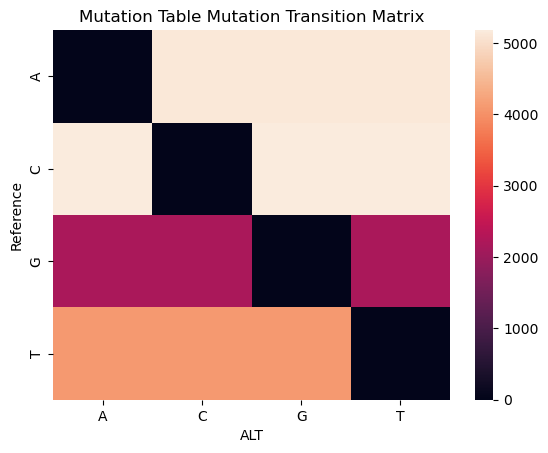

In [106]:
plt.title("Mutation Table Mutation Transition Matrix")
sns.heatmap(pd.crosstab(mutation_table_["Reference"], mutation_table_["ALT"] ) );

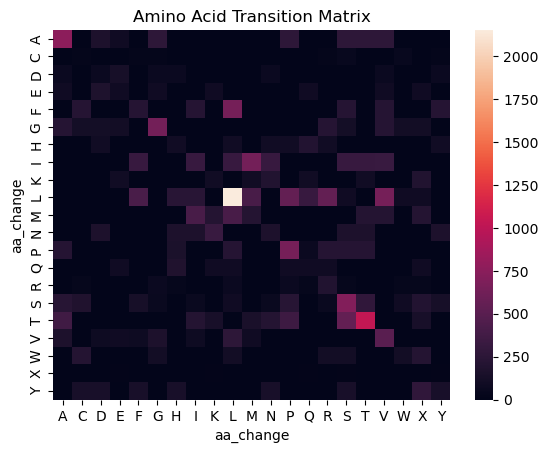

In [100]:
plt.title("Amino Acid Transition Matrix")
sns.heatmap(pd.crosstab(mutation_table_["aa_change"].str[0], mutation_table_["aa_change"].str[-1]) );

Add zero to disease score for all mutations with aa_changes but no disease score assigned.
This is based on the assumption that if the SNP causes a DNA change, but doesn't causes the disease score, then it has zero disease score. 
We modify the mutpred scores in the same way

Text(0.5, 1.0, 'Disease Scores Pre-Modification')

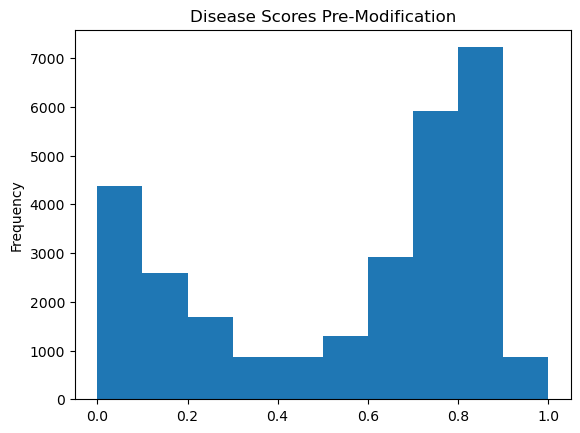

In [108]:
mutation_table_["disease_score"].plot.hist()
plt.title("Disease Scores Pre-Modification")

In [109]:
mutation_table_.loc[(mutation_table_["disease_score"].isna()) & ~mutation_table_["aa_change"].isna(), "disease_score"] = 0

Text(0.5, 1.0, 'Disease Scores Post-Modification')

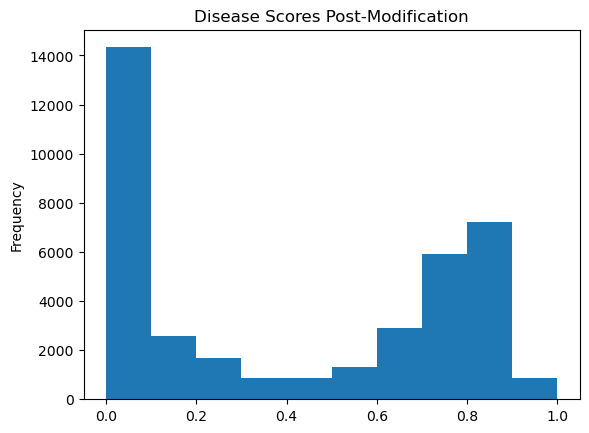

In [110]:
mutation_table_["disease_score"].plot.hist()
plt.title("Disease Scores Post-Modification")

In [111]:
mutation_table_.loc[(mutation_table_["mutPred_prob"].isna()) & ~mutation_table_["aa_change"].isna(),"mutPred_prob"] = 0

<AxesSubplot: ylabel='Frequency'>

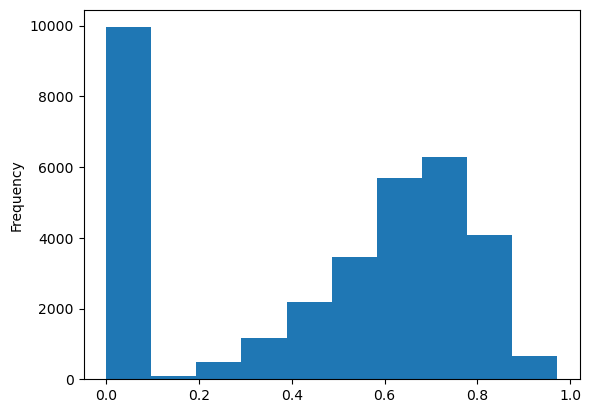

In [112]:
mutation_table_["mutPred_prob"].plot.hist()

In [113]:
mutation_table_.to_csv("../../config_dir/mtDNA_annotations/Comprehensive_mtDNA_annotations.csv")

In [124]:
# add boolean to indicate whether the mutation is synonymous or not
mutation_table_["synonymous_bl"] = mutation_table_["aa_change"].str[0] == mutation_table_["aa_change"].str[-1] #.set_index("group").loc["CDS"]

In [128]:
mutation_table_

Unnamed: 0  Position Reference ALT pathogenicity_x  patho_score  \
0             0.0         1         G   T          Uknown          0.0   
1             1.0         1         G   A          Uknown          0.0   
2             2.0         1         G   C          Uknown          0.0   
3             3.0         2         A   T          Uknown          0.0   
4             4.0         2         A   G          Uknown          0.0   
...           ...       ...       ...  ..             ...          ...   
49710     49702.0     16568         T   A          Uknown          0.0   
49711     49703.0     16568         T   C          Uknown          0.0   
49712     49704.0     16569         G   T          Uknown          0.0   
49713     49705.0     16569         G   A          Uknown          0.0   
49714     49706.0     16569         G   C          Uknown          0.0   

      Mutation MutationID locus _entry  ... polyphen2_humDiv_prob  \
0          G>T       1G>T   NaN    NaN  ...                   NaN   
1          G>A       1G>A   NaN    NaN  ...                   NaN   
2          G>C       1G>C   NaN    NaN  ...                   NaN   
3          A>T       2A>T   NaN    NaN  ...                   NaN   
4          A>G       2A>G   NaN    NaN  ...                   NaN   
...        ...        ...   ...    ...  ...                   ...   
49710      T>A   16568T>A   NaN    NaN  ...                   NaN   
49711      T>C   16568T>C   NaN    NaN  ...                   NaN   
49712      G>T   16569G>T   NaN    NaN  ...                   NaN   
49713      G>A   16569G>A   NaN    NaN  ...                   NaN   
49714      G>C   16569G>C   NaN    NaN  ...                   NaN   

      polyphen2_humVar_pred  polyphen2_humVar_prob  snp_go_pred snp_go_prob  \
0                       NaN                    NaN          NaN         NaN   
1                       NaN                    NaN          NaN         NaN   
2                       NaN                    NaN          NaN         NaN   
3                       NaN                    NaN          NaN         NaN   
4                       NaN                    NaN          NaN         NaN   
...                     ...                    ...          ...         ...   
49710                   NaN                    NaN          NaN         NaN   
49711                   NaN                    NaN          NaN         NaN   
49712                   NaN                    NaN          NaN         NaN   
49713                   NaN                    NaN          NaN         NaN   
49714                   NaN                    NaN          NaN         NaN   

          _merge  mean_pathos Description Strand synonymous_bl  
0      left_only          NaN         NaN    NaN         False  
1      left_only          NaN         NaN    NaN         False  
2      left_only          NaN         NaN    NaN         False  
3      left_only          NaN         NaN    NaN         False  
4      left_only          NaN         NaN    NaN         False  
...          ...          ...         ...    ...           ...  
49710  left_only          NaN         NaN    NaN         False  
49711  left_only          NaN         NaN    NaN         False  
49712  left_only          NaN         NaN    NaN         False  
49713  left_only          NaN         NaN    NaN         False  
49714  left_only          NaN         NaN    NaN         False  

[49715 rows x 41 columns]

In [131]:
mutation_table_.groupby(["group", "synonymous_bl"]).size() # sanity check that only protein coding sequences are have synonymous values

group  synonymous_bl
CDS    False            25788
       True              8239
rRNA   False              773
tRNA   False             4515
dtype: int64

In [132]:
mutation_table_ = pd.read_csv("../../config_dir/mtDNA_annotations/Comprehensive_mtDNA_annotations.csv")

/var/tmp/pbs.6394162.pbs/ipykernel_1188193/3082300429.py:1: DtypeWarning: Columns (9,10,11,12,15,16,18,19,20,23,24,25,27,29,31,33,35,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table_ = pd.read_csv("../../config_dir/mtDNA_annotations/Comprehensive_mtDNA_annotations.csv")


In [136]:
mutation_table_.filter(regex=r".*prob.*", axis=1).dropna().dtypes

mutPred_prob             float64
panther_prob             float64
phD_snp_prob             float64
polyphen2_humDiv_prob    float64
polyphen2_humVar_prob    float64
snp_go_prob              float64
dtype: object

In [139]:
sns.pairplot(data=mutation_table_.filter(regex=r".*prob.*", axis=1).dropna(),
             diag_kind="kde",
             kind="reg",
            plot_kws=dict(scatter_kws=dict(s=2, alpha=0.2)),
            diag_kws= {'cut': 0},
            height=2.5)

In [22]:
sns.histplot(data=mutation_table_,
           x="disease_score",
           hue="Type",
            bins=np.linspace(-0.0,1.,11),
            common_norm=False,
            stat="density"
           )

<AxesSubplot: xlabel='disease_score', ylabel='Density'>

In [17]:
np.linspace(-0.0,1.,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [132]:
plot_df = pd.DataFrame.from_dict({'mutPred_prob': 24047,
 'panther_prob': 21077,
 'phD_snp_prob': 23967,
 'polyphen2_humDiv_prob': 23901,
 'polyphen2_humVar_prob': 23901,
 'snp_go_prob': 23967,
"Potential Mutations":49715}, orient="index", columns=["Counts"]) #.reset_ind

In [134]:
plot_df.index.names = ["Feature"]
plot_df.reset_index()

Feature  Counts
0           mutPred_prob   24047
1           panther_prob   21077
2           phD_snp_prob   23967
3  polyphen2_humDiv_prob   23901
4  polyphen2_humVar_prob   23901
5            snp_go_prob   23967
6    Potential Mutations   49715

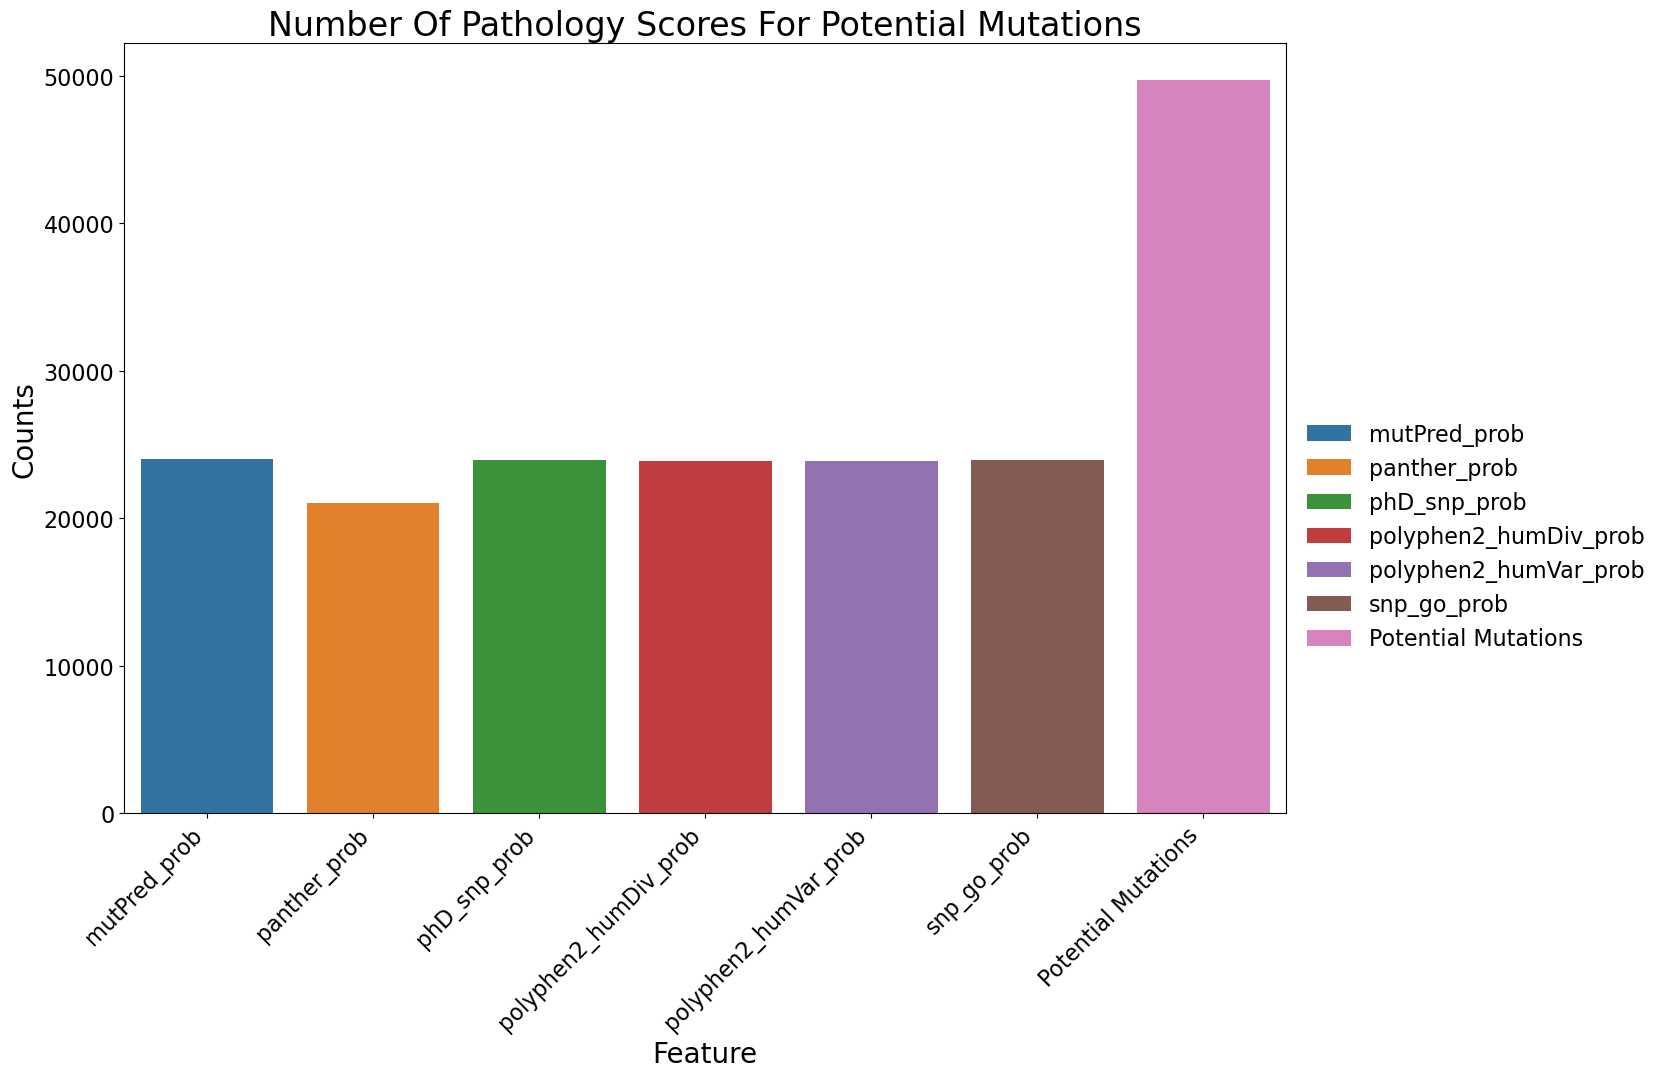

In [140]:
with plt.rc_context(rc_config):
    _, axs = plt.subplots(1,1, figsize=(15,10))
    sns.barplot(data=plot_df.reset_index(),
               x="Feature", y="Counts",
               hue="Feature",
               dodge=False)
    plt.legend(loc=(1.01,0.2))
    plt.title("Number of pathology scores for potential mutations".title())
    axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha="right")

In [124]:
(mutation_table_[['mutPred_prob', 'panther_prob', 'phD_snp_prob', 'polyphen2_humDiv_prob',
       'polyphen2_humVar_prob', 'snp_go_prob']].apply(lambda x: np.sum(~np.isnan(x)) )).to_dict()

{'mutPred_prob': 24047,
 'panther_prob': 21077,
 'phD_snp_prob': 23967,
 'polyphen2_humDiv_prob': 23901,
 'polyphen2_humVar_prob': 23901,
 'snp_go_prob': 23967}

In [127]:
mutation_table_

Unnamed: 0  Position Reference ALT pathogenicity_x  patho_score  \
0             0.0         1         G   T          Uknown          0.0   
1             1.0         1         G   A          Uknown          0.0   
2             2.0         1         G   C          Uknown          0.0   
3             3.0         2         A   T          Uknown          0.0   
4             4.0         2         A   G          Uknown          0.0   
...           ...       ...       ...  ..             ...          ...   
49710     49702.0     16568         T   A          Uknown          0.0   
49711     49703.0     16568         T   C          Uknown          0.0   
49712     49704.0     16569         G   T          Uknown          0.0   
49713     49705.0     16569         G   A          Uknown          0.0   
49714     49706.0     16569         G   C          Uknown          0.0   

      Mutation MutationID locus _entry  ... phD_snp_prob  \
0          G>T       1G>T   NaN    NaN  ...          NaN   
1          G>A       1G>A   NaN    NaN  ...          NaN   
2          G>C       1G>C   NaN    NaN  ...          NaN   
3          A>T       2A>T   NaN    NaN  ...          NaN   
4          A>G       2A>G   NaN    NaN  ...          NaN   
...        ...        ...   ...    ...  ...          ...   
49710      T>A   16568T>A   NaN    NaN  ...          NaN   
49711      T>C   16568T>C   NaN    NaN  ...          NaN   
49712      G>T   16569G>T   NaN    NaN  ...          NaN   
49713      G>A   16569G>A   NaN    NaN  ...          NaN   
49714      G>C   16569G>C   NaN    NaN  ...          NaN   

      polyphen2_humDiv_pred  polyphen2_humDiv_prob  polyphen2_humVar_pred  \
0                       NaN                    NaN                    NaN   
1                       NaN                    NaN                    NaN   
2                       NaN                    NaN                    NaN   
3                       NaN                    NaN                    NaN   
4                       NaN                    NaN                    NaN   
...                     ...                    ...                    ...   
49710                   NaN                    NaN                    NaN   
49711                   NaN                    NaN                    NaN   
49712                   NaN                    NaN                    NaN   
49713                   NaN                    NaN                    NaN   
49714                   NaN                    NaN                    NaN   

      polyphen2_humVar_prob snp_go_pred  snp_go_prob     _merge mean_pathos  \
0                       NaN         NaN          NaN  left_only         NaN   
1                       NaN         NaN          NaN  left_only         NaN   
2                       NaN         NaN          NaN  left_only         NaN   
3                       NaN         NaN          NaN  left_only         NaN   
4                       NaN         NaN          NaN  left_only         NaN   
...                     ...         ...          ...        ...         ...   
49710                   NaN         NaN          NaN  left_only         NaN   
49711                   NaN         NaN          NaN  left_only         NaN   
49712                   NaN         NaN          NaN  left_only         NaN   
49713                   NaN         NaN          NaN  left_only         NaN   
49714                   NaN         NaN          NaN  left_only         NaN   

      Description  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
49710         NaN  
49711         NaN  
49712         NaN  
49713         NaN  
49714         NaN  

[49715 rows x 39 columns]

In [126]:
mutation_table_ .size #.to_frame("Potential Mutations")

1938885

In [120]:
num_muts_to_paths = pd.concat([(mutation_table_[['mutPred_prob', 'panther_prob', 'phD_snp_prob', 'polyphen2_humDiv_prob',
       'polyphen2_humVar_prob', 'snp_go_prob']].apply(lambda x: np.sum(~np.isnan(x)) )),
          mutation_table_.size[0].to_frame("Potential Mutations")], axis=0)

IndexError: invalid index to scalar variable.

In [111]:
num_muts_to_paths = pd.concat([(mutation_table_.groupby("locus")[['mutPred_prob', 'panther_prob', 'phD_snp_prob', 'polyphen2_humDiv_prob',
       'polyphen2_humVar_prob', 'snp_go_prob']].apply(lambda x: np.sum(~np.isnan(x)) )),
          mutation_table_.groupby("locus").size().to_frame("Potential Mutations")], axis=1) #.stack()

In [112]:
num_muts_to_paths.columns.names = ["Feature"]

In [113]:
with plt.rc_context(rc_config):
    _, axs = plt.subplots(1,1, figsize=(25,10))
    sns.barplot(data=num_muts_to_paths.stack().to_frame("Counts").reset_index(),
               x="locus",
               y="Counts",
               hue="Feature")
    plt.title("MT RNRs 1 & 2 are missing annotations")
    axs.get_xticklabels
    axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha="right")

In [252]:
display(10)

10

<AxesSubplot: xlabel='aa_change,mutPred_prob'>

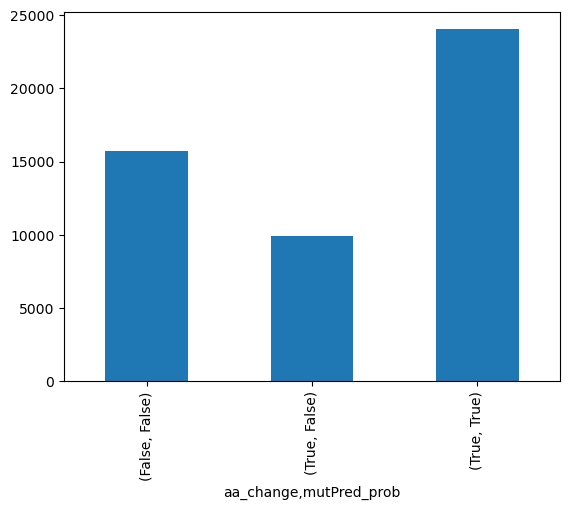

In [206]:
(~mutation_table_[["aa_change","mutPred_prob"]].isna()).groupby(["aa_change","mutPred_prob"]).size().plot.bar() #.isna() ).value_counts().plot.bar()

In [212]:
test = ~mutation_table_.set_index(["MutationID","Position"])[["aa_change","mutPred_prob"]].isna()

In [220]:
test[(test["aa_change"] == True) & (test["mutPred_prob"] == False)]

aa_change  mutPred_prob
MutationID Position                         
3308T>G    3308           True         False
3309A>G    3309           True         False
3312C>T    3312           True         False
3312C>G    3312           True         False
3312C>A    3312           True         False
...                        ...           ...
15886C>G   15886          True         False
15886C>A   15886          True         False
15887T>G   15887          True         False
15887T>A   15887          True         False
15887T>C   15887          True         False

[9941 rows x 2 columns]

In [239]:
mutation_table_["MutationID"].value_counts() #.value_counts()

3107N>NA    3
4279A>G     3
9509T>C     2
9947G>A     2
12239C>T    2
           ..
5526A>T     1
5526A>G     1
5526A>C     1
5527A>T     1
16569G>C    1
Name: MutationID, Length: 49705, dtype: int64

In [246]:
pd.set_option('display.max_columns', 40)

In [250]:
mutation_table_[mutation_table_["MutationID"] == "9947G>A"]

Unnamed: 0  Position Reference ALT pathogenicity_x  patho_score  \
29844     29839.0      9947         G   A          Uknown          0.0   
29845     29839.0      9947         G   A          Uknown          0.0   

      Mutation MutationID   locus                                   _entry  \
29844      G>A    9947G>A  MT-CO3  https://www.hmtvar.uniba.it/api/main...   
29845      G>A    9947G>A  MT-CO3  https://www.hmtvar.uniba.it/api/main...   

      aa_change alt  codon_position  disease_score group  \
29844     V247V   A             3.0            NaN   CDS   
29845     V247V   A             3.0            NaN   CDS   

                                   haplogroups       id pathogenicity_y  \
29844  I1a1a1;I1a1a3;I1a1a2;I1a1d;F3b;F3b_1...  17439.0            None   
29845  I1a1a1;I1a1a3;I1a1a2;I1a1d;F3b;F3b_1...  17440.0            None   

      ref_rCRS base model  model_position stem_loop strutt_3 mutPred_pred  \
29844        G  NaN   NaN             NaN       NaN      NaN         None   
29845        G  NaN   NaN             NaN       NaN      NaN         None   

       mutPred_prob panther_pred  panther_prob phD_snp_pred  phD_snp_prob  \
29844           NaN         None           NaN         None           NaN   
29845           NaN         None           NaN         None           NaN   

      polyphen2_humDiv_pred  polyphen2_humDiv_prob polyphen2_humVar_pred  \
29844                  None                    NaN                  None   
29845                  None                    NaN                  None   

       polyphen2_humVar_prob snp_go_pred  snp_go_prob _merge  mean_pathos  \
29844                    NaN        None          NaN   both          NaN   
29845                    NaN        None          NaN   both          NaN   

                            Description  
29844  Cytochrome c oxidase subunit III  
29845  Cytochrome c oxidase subunit III

In [240]:
3107N>NA

SyntaxError: invalid decimal literal (376403790.py, line 1)

In [236]:
mutation_table_[mutation_table_["MutationID"] == "8865G>A"] #.drop_duplicates().iloc[:,15:] #.diff()

Unnamed: 0  Position Reference ALT pathogenicity_x  patho_score  \
26596     26593.0      8865         G   A          Uknown          0.0   
26597     26593.0      8865         G   A          Uknown          0.0   

      Mutation MutationID    locus  \
26596      G>A    8865G>A  MT-ATP6   
26597      G>A    8865G>A  MT-ATP6   

                                           _entry  ... phD_snp_prob  \
26596  https://www.hmtvar.uniba.it/api/main/14883  ...          NaN   
26597  https://www.hmtvar.uniba.it/api/main/14884  ...          NaN   

      polyphen2_humDiv_pred  polyphen2_humDiv_prob  polyphen2_humVar_pred  \
26596                  None                    NaN                   None   
26597                  None                    NaN                   None   

      polyphen2_humVar_prob snp_go_pred  snp_go_prob _merge mean_pathos  \
26596                   NaN        None          NaN   both         NaN   
26597                   NaN        None          NaN   both         NaN   

                     Description  
26596  ATP synthase F0 subunit 6  
26597  ATP synthase F0 subunit 6  

[2 rows x 39 columns]

In [223]:
test[(test["aa_change"] == True) & (test["mutPred_prob"] == False)].groupby("Position").size()[test[(test["aa_change"] == True) & (test["mutPred_prob"] == False)].groupby("Position").size() == 4]

Position
8865     4
9947     4
15217    4
dtype: int64

In [222]:
with plt.rc_context(rc_config):
    _, axs = plt.subplots(1,1, figsize=(25,10))
    test[(test["aa_change"] == True) & (test["mutPred_prob"] == False)].groupby("Position").size().plot()

<AxesSubplot: >

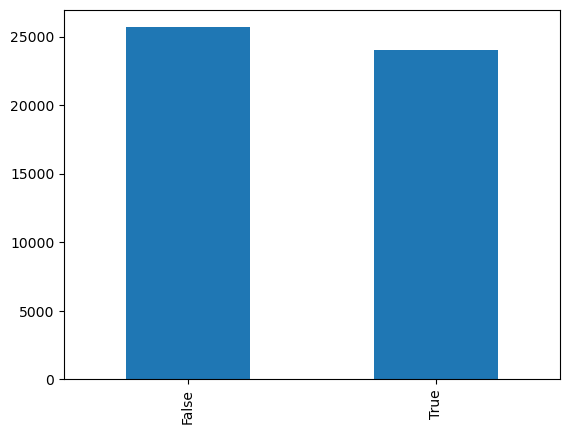

In [197]:
(~mutation_table_["mutPred_prob"].isna()).value_counts().plot.bar()

In [183]:
pd.isnull(mutation_table_["aa_change"]) #.value_counts()

0        True
1        True
2        True
3        True
4        True
         ... 
49710    True
49711    True
49712    True
49713    True
49714    True
Name: aa_change, Length: 49715, dtype: bool

In [190]:
plt.title("Has AA change at position")
mutation_table_.groupby("Position")["aa_change"].apply( lambda x : (np.sum( ~pd.isnull(x) ) > 0)*1  ).plot()

<AxesSubplot: title={'center': 'Has AA change at position'}, xlabel='Position'>

In [171]:
mutation_table_["model"].dropna().value_counts().plot()

<AxesSubplot: >

<AxesSubplot: >

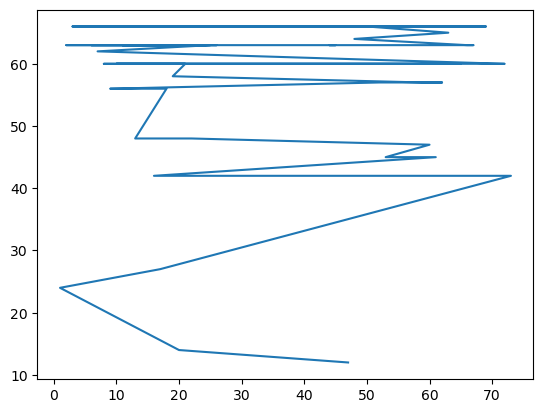

In [172]:
mutation_table_["model_position"].dropna().value_counts().plot()

In [153]:
mutation_table_[["mutPred_pred","mutPred_prob"]].astype(float).plot.scatter("mutPred_pred","mutPred_prob")

ValueError: could not convert string to float: 'low_pathogenicity'

In [148]:
mutation_table_["stem_loop"].value_counts()

AS    848
CS    672
TS    587
DS    468
CL    462
TL    458
DL    401
VL    268
-     179
E      42
Name: stem_loop, dtype: int64

In [96]:
axs.set_xticklabels??

Signature: axs.set_xticklabels(labels, *, fontdict=None, minor=False, **kwargs)
Docstring:
Set the xaxis' labels with list of string labels.

.. warning::
    This method should only be used after fixing the tick positions
    using `.Axes.set_xticks`. Otherwise, the labels may end up in
    unexpected positions.

Parameters
----------
labels : list of str
    The label texts.

fontdict : dict, optional
    A dictionary controlling the appearance of the ticklabels.
    The default *fontdict* is::

       {'fontsize': rcParams['axes.titlesize'],
        'fontweight': rcParams['axes.titleweight'],
        'verticalalignment': 'baseline',
        'horizontalalignment': loc}

minor : bool, default: False
    Whether to set the minor ticklabels rather than the major ones.

Returns
-------
list of `.Text`
    The labels.

Other Parameters
----------------
**kwargs : `~.text.Text` properties.
Source:   
        def wrapper(self, *args, **kwargs):
            return get_method(self)(*args, **k

In [93]:
axs.get_xticklabels()

[Text(0, 0, 'MT-ATP6'),
 Text(1, 0, 'MT-ATP8'),
 Text(2, 0, 'MT-CO1'),
 Text(3, 0, 'MT-CO2'),
 Text(4, 0, 'MT-CO3'),
 Text(5, 0, 'MT-CYB'),
 Text(6, 0, 'MT-ND1'),
 Text(7, 0, 'MT-ND2'),
 Text(8, 0, 'MT-ND3'),
 Text(9, 0, 'MT-ND4'),
 Text(10, 0, 'MT-ND4L'),
 Text(11, 0, 'MT-ND5'),
 Text(12, 0, 'MT-ND6'),
 Text(13, 0, 'MT-RNR1'),
 Text(14, 0, 'MT-RNR2'),
 Text(15, 0, 'MT-TA'),
 Text(16, 0, 'MT-TC'),
 Text(17, 0, 'MT-TD'),
 Text(18, 0, 'MT-TE'),
 Text(19, 0, 'MT-TF'),
 Text(20, 0, 'MT-TG'),
 Text(21, 0, 'MT-TH'),
 Text(22, 0, 'MT-TI'),
 Text(23, 0, 'MT-TK'),
 Text(24, 0, 'MT-TL1'),
 Text(25, 0, 'MT-TL2'),
 Text(26, 0, 'MT-TM'),
 Text(27, 0, 'MT-TN'),
 Text(28, 0, 'MT-TP'),
 Text(29, 0, 'MT-TQ'),
 Text(30, 0, 'MT-TR'),
 Text(31, 0, 'MT-TS1'),
 Text(32, 0, 'MT-TS2'),
 Text(33, 0, 'MT-TT'),
 Text(34, 0, 'MT-TV'),
 Text(35, 0, 'MT-TW'),
 Text(36, 0, 'MT-TY')]

<AxesSubplot: xlabel='Position'>

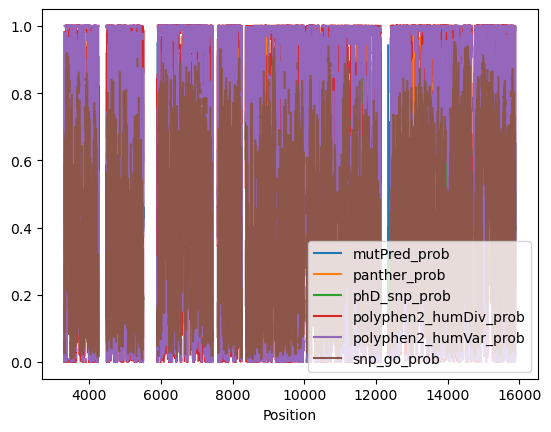

In [32]:
mutation_table_.set_index("Position").groupby("Position").head(1).filter(regex=r".*prob").astype(float).plot()

In [63]:
(~mutation_table_.set_index("locus")[['mutPred_prob', 'panther_prob', 'phD_snp_prob', 'polyphen2_humDiv_prob',
       'polyphen2_humVar_prob', 'snp_go_prob']].isna())

mutPred_prob  panther_prob  phD_snp_prob  polyphen2_humDiv_prob  \
locus                                                                    
NaN           False         False         False                  False   
NaN           False         False         False                  False   
NaN           False         False         False                  False   
NaN           False         False         False                  False   
NaN           False         False         False                  False   
...             ...           ...           ...                    ...   
NaN           False         False         False                  False   
NaN           False         False         False                  False   
NaN           False         False         False                  False   
NaN           False         False         False                  False   
NaN           False         False         False                  False   

       polyphen2_humVar_prob  snp_go_prob  
locus                                      
NaN                    False        False  
NaN                    False        False  
NaN                    False        False  
NaN                    False        False  
NaN                    False        False  
...                      ...          ...  
NaN                    False        False  
NaN                    False        False  
NaN                    False        False  
NaN                    False        False  
NaN                    False        False  

[49715 rows x 6 columns]

In [56]:
mutation_table_.set_index("Position").groupby("Position").head(1).filter(regex=r".*prob").columns #.isna()).sum().plot.bar()

Index(['mutPred_prob', 'panther_prob', 'phD_snp_prob', 'polyphen2_humDiv_prob',
       'polyphen2_humVar_prob', 'snp_go_prob'],
      dtype='object')

<AxesSubplot: >

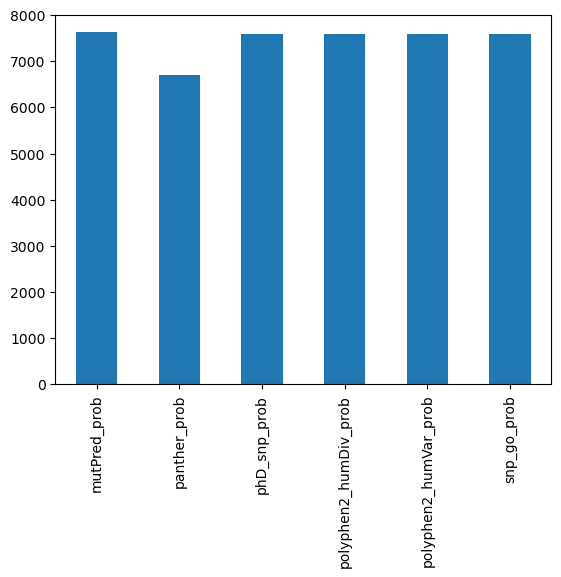

In [51]:
(~mutation_table_.set_index("Position").groupby("Position").head(1).filter(regex=r".*prob").isna()).sum().plot.bar()

In [34]:
mutation_table_.set_index("Position").groupby("Position").head(1).filter(regex=r".*prob").dropna()

mutPred_prob  panther_prob  phD_snp_prob  polyphen2_humDiv_prob  \
Position                                                                    
3401             0.833         0.745         0.850                  0.997   
3402             0.838         0.479         0.868                  0.999   
3404             0.642         0.165         0.802                  0.974   
3406             0.898         0.942         0.816                  1.000   
3407             0.921         0.801         0.798                  1.000   
...                ...           ...           ...                    ...   
15796            0.548         0.455         0.416                  0.995   
15797            0.774         0.957         0.762                  1.000   
15798            0.735         0.415         0.689                  1.000   
15801            0.621         0.569         0.721                  0.986   
15802            0.664         0.646         0.808                  0.998   

          polyphen2_humVar_prob  snp_go_prob  
Position                                      
3401                      0.998        0.752  
3402                      0.999        0.580  
3404                      0.964        0.334  
3406                      1.000        0.820  
3407                      0.999        0.848  
...                         ...          ...  
15796                     0.997        0.286  
15797                     0.999        0.777  
15798                     0.996        0.697  
15801                     0.979        0.710  
15802                     0.996        0.629  

[6703 rows x 6 columns]

In [36]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(mutation_table_.set_index("Position").groupby("Position").head(1).filter(regex=r".*prob").dropna())

PCA()

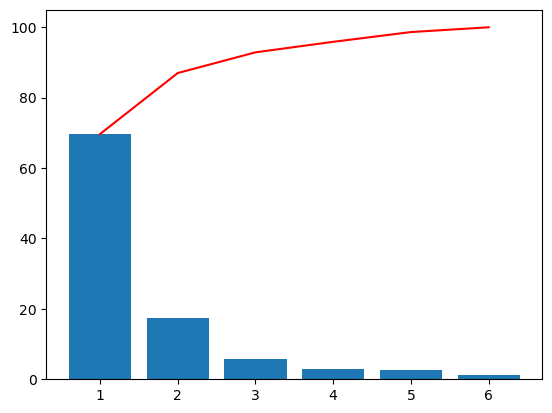

In [46]:
plt.bar(range(1,7), pca.explained_variance_ratio_*100)
plt.plot(range(1,7), np.cumsum(pca.explained_variance_ratio_*100), zorder=2, c="red")

In [100]:
mutation_table_["locus"].map()

Unnamed: 0  Position Reference ALT pathogenicity_x  patho_score  \
0             0.0         1         G   T          Uknown          0.0   
1             1.0         1         G   A          Uknown          0.0   
2             2.0         1         G   C          Uknown          0.0   
3             3.0         2         A   T          Uknown          0.0   
4             4.0         2         A   G          Uknown          0.0   
...           ...       ...       ...  ..             ...          ...   
49710     49702.0     16568         T   A          Uknown          0.0   
49711     49703.0     16568         T   C          Uknown          0.0   
49712     49704.0     16569         G   T          Uknown          0.0   
49713     49705.0     16569         G   A          Uknown          0.0   
49714     49706.0     16569         G   C          Uknown          0.0   

      Mutation MutationID locus _entry  ... phD_snp_pred phD_snp_prob  \
0          G>T       1G>T   NaN    NaN  ...          NaN          NaN   
1          G>A       1G>A   NaN    NaN  ...          NaN          NaN   
2          G>C       1G>C   NaN    NaN  ...          NaN          NaN   
3          A>T       2A>T   NaN    NaN  ...          NaN          NaN   
4          A>G       2A>G   NaN    NaN  ...          NaN          NaN   
...        ...        ...   ...    ...  ...          ...          ...   
49710      T>A   16568T>A   NaN    NaN  ...          NaN          NaN   
49711      T>C   16568T>C   NaN    NaN  ...          NaN          NaN   
49712      G>T   16569G>T   NaN    NaN  ...          NaN          NaN   
49713      G>A   16569G>A   NaN    NaN  ...          NaN          NaN   
49714      G>C   16569G>C   NaN    NaN  ...          NaN          NaN   

       polyphen2_humDiv_pred  polyphen2_humDiv_prob polyphen2_humVar_pred  \
0                        NaN                    NaN                   NaN   
1                        NaN                    NaN                   NaN   
2                        NaN                    NaN                   NaN   
3                        NaN                    NaN                   NaN   
4                        NaN                    NaN                   NaN   
...                      ...                    ...                   ...   
49710                    NaN                    NaN                   NaN   
49711                    NaN                    NaN                   NaN   
49712                    NaN                    NaN                   NaN   
49713                    NaN                    NaN                   NaN   
49714                    NaN                    NaN                   NaN   

      polyphen2_humVar_prob  snp_go_pred snp_go_prob     _merge mean_pathos  
0                       NaN          NaN         NaN  left_only         NaN  
1                       NaN          NaN         NaN  left_only         NaN  
2                       NaN          NaN         NaN  left_only         NaN  
3                       NaN          NaN         NaN  left_only         NaN  
4                       NaN          NaN         NaN  left_only         NaN  
...                     ...          ...         ...        ...         ...  
49710                   NaN          NaN         NaN  left_only         NaN  
49711                   NaN          NaN         NaN  left_only         NaN  
49712                   NaN          NaN         NaN  left_only         NaN  
49713                   NaN          NaN         NaN  left_only         NaN  
49714                   NaN          NaN         NaN  left_only         NaN  

[49715 rows x 38 columns]

In [67]:
test =  pca.fit_transform(mutation_table_.set_index("Position").groupby("Position").head(1).filter(regex=r".*prob").dropna())[:,:2]

In [71]:
test_df =mutation_table_.set_index("Position").groupby("Position").head(1).filter(regex=r".*prob").dropna()

In [72]:
test_df[["pca1","pca2"]] = test

In [73]:
test_df

mutPred_prob  panther_prob  phD_snp_prob  polyphen2_humDiv_prob  \
Position                                                                    
3401             0.833         0.745         0.850                  0.997   
3402             0.838         0.479         0.868                  0.999   
3404             0.642         0.165         0.802                  0.974   
3406             0.898         0.942         0.816                  1.000   
3407             0.921         0.801         0.798                  1.000   
...                ...           ...           ...                    ...   
15796            0.548         0.455         0.416                  0.995   
15797            0.774         0.957         0.762                  1.000   
15798            0.735         0.415         0.689                  1.000   
15801            0.621         0.569         0.721                  0.986   
15802            0.664         0.646         0.808                  0.998   

          polyphen2_humVar_prob  snp_go_prob      pca1      pca2  
Position                                                          
3401                      0.998        0.752 -0.533533  0.313615  
3402                      0.999        0.580 -0.427708  0.052638  
3404                      0.964        0.334 -0.201153 -0.310923  
3406                      1.000        0.820 -0.608161  0.471746  
3407                      0.999        0.848 -0.581513  0.402881  
...                         ...          ...       ...       ...  
15796                     0.997        0.286 -0.208828 -0.293703  
15797                     0.999        0.777 -0.568970  0.424937  
15798                     0.996        0.697 -0.393698  0.027502  
15801                     0.979        0.710 -0.401509  0.130937  
15802                     0.996        0.629 -0.439259  0.146571  

[6703 rows x 8 columns]

In [91]:
(~mutation_table_.disease_score.isna()).sum()

28530

In [162]:
mutation_table_["aa_change"].drop_duplicates().str.split(r"\d*", regex=True).str[3].value_counts()

S    1821
L    1657
V    1596
T    1443
P    1373
A    1249
I    1181
R    1082
X    1070
F     982
M     958
N     941
G     878
H     841
D     796
Y     726
C     687
K     682
Q     663
E     575
W     408
Name: aa_change, dtype: int64

<AxesSubplot: xlabel='aa_change', ylabel='aa_change'>

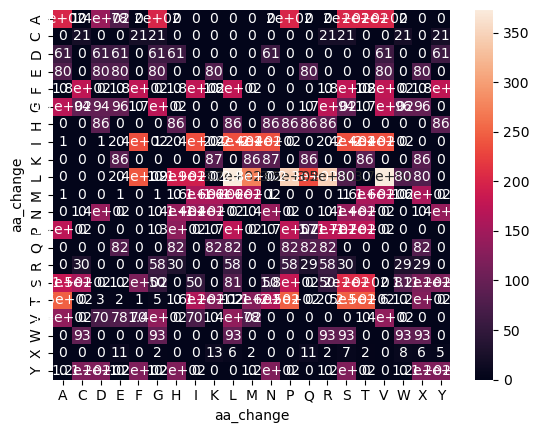

In [158]:
sns.heatmap(pd.crosstab(mutation_table_["aa_change"].drop_duplicates().str.split(r"\d*", regex=True).str[1],
            mutation_table_["aa_change"].drop_duplicates().str.split(r"\d*", regex=True).str[3]
           ),annot=True)

<AxesSubplot: xlabel='Position', ylabel='disease_score'>

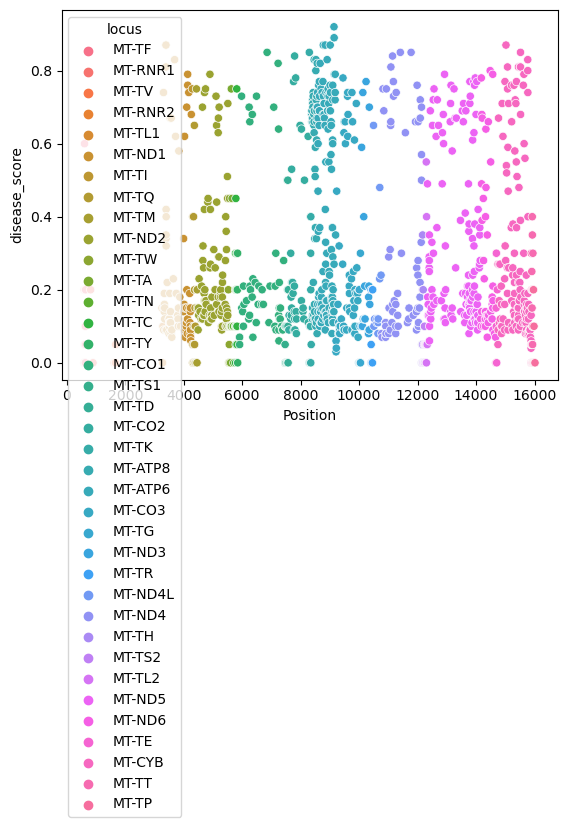

In [97]:
sns.scatterplot(data=mutation_table_[~mutation_table_["haplogroups"].isna()],
               x="Position",
               y="disease_score",
               hue="locus",
               edgecolors="none")

In [98]:
mutation_table_[~mutation_table_["haplogroups"].isna()]["haplogroups"]

1772                                                  P4b1
1777                                      L2a4b;L2a4;L2a4a
1778     K1a1b1b;H5a4a1a;L0k1b;T1a1d;M1a2b;K1a1b1b1;G1c...
1779                                               HV12b1a
1788     L0d2a1a3;L0d2a1a2;L0d2a1a1;L0d2a1c;L0d2a1b;L0d...
                               ...                        
47939    L1c3b;L1c3c;L1c3b'c;L1c3b1;L1c3b1b;L1c3;L1c3a;...
47956                                                 B4a3
48005                                                 M43b
48006                                      L3d3a1b;B4a1c3a
48058    G1b_16129!;L1c3b1;L1c3b1b;M2a1b;G1b2;G1b;L1c3b...
Name: haplogroups, Length: 3646, dtype: object

<AxesSubplot: xlabel='Position', ylabel='disease_score'>

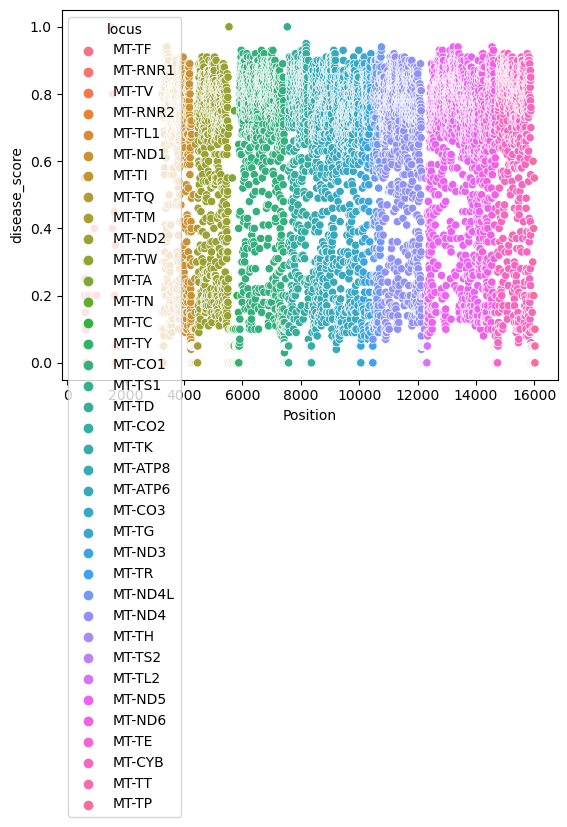

In [94]:
sns.scatterplot(data=mutation_table_.groupby("Position").head(1),
               x="Position",
               y="disease_score",
               hue="locus",
               edgecolors="none")

In [14]:
mutation_table_.groupby("Position")["mean_pathos"].mean().plot()

NameError: name 'mutation_table_' is not defined

In [376]:
annotations_df[annotations_df["locus"].isin(locus_positions.index)]

_entry aa_change alt  \
218      https://www.hmtvar.uniba.it/api/main/221      None   A   
219      https://www.hmtvar.uniba.it/api/main/222      None   C   
220      https://www.hmtvar.uniba.it/api/main/223      None   T   
221      https://www.hmtvar.uniba.it/api/main/224      None   A   
222      https://www.hmtvar.uniba.it/api/main/225      None   C   
...                                           ...       ...  ..   
40933  https://www.hmtvar.uniba.it/api/main/40995      None   C   
40934  https://www.hmtvar.uniba.it/api/main/40996      None   G   
40935  https://www.hmtvar.uniba.it/api/main/40997      None   G   
40936  https://www.hmtvar.uniba.it/api/main/40998      None   T   
40937  https://www.hmtvar.uniba.it/api/main/40999      None   C   

       codon_position  disease_score group haplogroups     id    locus  \
218               NaN           0.05  tRNA        None    221    MT-TF   
219               NaN           0.05  tRNA        None    222    MT-TF   
220               NaN           0.05  tRNA        None    223    MT-TF   
221               NaN           0.05  tRNA        None    224    MT-TF   
222               NaN           0.05  tRNA        None    225    MT-TF   
...               ...            ...   ...         ...    ...      ...   
40933             NaN            NaN  rRNA        None  40995  MT-RNR2   
40934             NaN            NaN  rRNA        None  40996  MT-RNR2   
40935             NaN            NaN  rRNA        None  40997  MT-RNR2   
40936             NaN            NaN  rRNA        None  40998  MT-RNR2   
40937             NaN            NaN  rRNA        None  40999  MT-RNR2   

       Position  ... panther_prob phD_snp_pred phD_snp_prob  \
218         577  ...          NaN         None          NaN   
219         577  ...          NaN         None          NaN   
220         577  ...          NaN         None          NaN   
221         578  ...          NaN         None          NaN   
222         578  ...          NaN         None          NaN   
...         ...  ...          ...          ...          ...   
40933      1545  ...          NaN         None          NaN   
40934      1583  ...          NaN         None          NaN   
40935      1584  ...          NaN         None          NaN   
40936      2220  ...          NaN         None          NaN   
40937      2336  ...          NaN         None          NaN   

      polyphen2_humDiv_pred  polyphen2_humDiv_prob polyphen2_humVar_pred  \
218                    None                    NaN                  None   
219                    None                    NaN                  None   
220                    None                    NaN                  None   
221                    None                    NaN                  None   
222                    None                    NaN                  None   
...                     ...                    ...                   ...   
40933                  None                    NaN                  None   
40934                  None                    NaN                  None   
40935                  None                    NaN                  None   
40936                  None                    NaN                  None   
40937                  None                    NaN                  None   

      polyphen2_humVar_prob snp_go_pred  snp_go_prob MutationID  
218                     NaN        None          NaN     577G>A  
219                     NaN        None          NaN     577G>C  
220                     NaN        None          NaN     577G>T  
221                     NaN        None          NaN     578T>A  
222                     NaN        None          NaN     578T>C  
...                     ...         ...          ...        ...  
40933                   NaN        None          NaN    1545T>C  
40934                   NaN        None          NaN    1583A>G  
40935                   NaN        None          NaN    1584A>G  
40936              

In [398]:
annotations_df[annotations_df["locus"].isin(locus_positions.index) & (annotations_df["MutationID"] == "8542T>G")]

_entry aa_change alt  \
14020  https://www.hmtvar.uniba.it/api/main/14024       F6V   G   
14021  https://www.hmtvar.uniba.it/api/main/14025      C59W   G   

       codon_position  disease_score group haplogroups     id    locus  \
14020             1.0           0.77   CDS        None  14024  MT-ATP6   
14021             3.0           0.27   CDS        None  14025  MT-ATP8   

       Position  ... panther_prob phD_snp_pred phD_snp_prob  \
14020      8542  ...        0.727      neutral        0.371   
14021      8542  ...        0.619      disease        0.596   

      polyphen2_humDiv_pred  polyphen2_humDiv_prob polyphen2_humVar_pred  \
14020     probably_damaging                  0.990     probably_damaging   
14021                benign                  0.033                benign   

      polyphen2_humVar_prob snp_go_pred  snp_go_prob MutationID  
14020                 0.944     neutral        0.381    8542T>G  
14021                 0.010     neutral        0.361    8542T>G  

[2 rows x 30 columns]

In [385]:
mutation_table_[(mutation_table_["_merge"] == "right_only") & (mutation_table_["locus"] == "MT-ATP6")].groupby("MutationID").size().sort_values() #["locus"].value_counts()

MutationID
8527A>C    1
8561C>A    1
8560C>T    1
8560C>G    1
8560C>A    1
          ..
8542T>G    1
8543T>A    1
8543T>C    1
8541G>C    1
8573G>T    1
Length: 141, dtype: int64

In [38]:
keys = ['disease_score', 'mutPred_prob', 'panther_prob',
       'phD_snp_prob', 'polyphen2_humDiv_prob', 'polyphen2_humVar_prob',
       'snp_go_prob']

In [39]:
sns.heatmap(df[keys].dropna().corr(), vmin=0, vmax=1, annot=True)

<AxesSubplot: >

In [60]:
rc_config = {'axes.titlesize': 24.0,
 'axes.labelsize': 10.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'figure.titlesize': 35.5,
 'figure.facecolor': 'white',
 'legend.frameon': False,
 'legend.fontsize': 8.0}

In [ ]:
with plt.rc_context(rc_config):
    plot = sns.pairplot(df[keys].dropna(), kind="kde", diag_kind="kde",
#                  plot_kws=dict(scatter_kws=dict(s=2, alpha=0.2)),
                        diag_kws= {'cut': 0},
                        height=2.5
                )
    plot.fig.suptitle("Different Pathology Score Metrics Are Only Loosely Related", y=1.05)